# Matplotlib: lotka volterra tutorial

1. page was renamed from LotkaVolterraTutorial

This example describes how to integrate ODEs with the scipy.integrate
module, and how to use the matplotlib module to plot trajectories,
direction fields and other information.

You can get the source code for this tutorial here:
[tutorial_lotka-voltera_v4.py](files/attachments/LotkaVolterraTutorial/tutorial_lotka-voltera_v4.py).

Presentation of the Lotka-Volterra Model
----------------------------------------

We will have a look at the Lotka-Volterra model, also known as the
predator-prey equations, which is a pair of first order, non-linear,
differential equations frequently used to describe the dynamics of
biological systems in which two species interact, one a predator and the
other its prey. The model was proposed independently by Alfred J. Lotka
in 1925 and Vito Volterra in 1926, and can be described by

$$
\frac{du}{dt} =  a\cdot u - b \cdot u \cdot v  
$$
$$
\frac{dv}{dt} = -c \cdot v + d \cdot b \cdot u \cdot v
$$

with the following notations:

*  u: number of preys (for example, rabbits)

*  v: number of predators (for example, foxes)  
  
* a, b, c, d are constant parameters defining the behavior of the population:    

  + a is the natural growing rate of rabbits, when there's no fox

  + b is the natural dying rate of rabbits, due to predation

  + c is the natural dying rate of fox, when there's no rabbit

  + d is the factor describing how many caught rabbits let create a new fox

We will use X=[u, v] to describe the state of both populations.

Definition of parameters

In [1]:
a = 1.
b = 0.1
c = 1.5
d = 0.75

Definition of the equations

In [2]:
import numpy as np

def dX_dt(t, X):
    """Return the growth rate of fox and rabbit populations"""
    return np.array([a*X[0] - b*X[0]*X[1],
                    -c*X[1] + d*b*X[0]*X[1]])

### Population equilibrium

Before using `solve_ivp` to integrate this system, we will have a closer look
at position equilibrium. Equilibrium occurs when the growth rate is
equal to 0. This gives two fixed points:

In [3]:
X_f0 = np.array([0, 0])
X_f1 = np.array([c/(d*b), a/b])

assert np.all(dX_dt(0, X_f0) == np.zeros(2)) and np.all(dX_dt(0, X_f1) == np.zeros(2))

### Stability of the fixed points

Near these two points, the system can be linearized: dX\_dt = A\_f\*X
where A is the Jacobian matrix evaluated at the corresponding point. We
have to define the Jacobian matrix:

In [4]:
def d2X_dt2(t, X):
    """Return the Jacobian matrix evaluated in X"""
    return np.array([[a -b*X[1], -b*X[0]],
                     [b * d * X[1], -c + b * d * X[0]]])

So near X\_f0, which represents the extinction of both species, we have:

In [5]:
A_f0 = d2X_dt2(0, X_f0)
A_f0

array([[ 1. , -0. ],
       [ 0. , -1.5]])

Near X\_f0, the number of rabbits increase and the population of foxes
decrease. The origin is therefore a [saddle
point](http://en.wikipedia.org/wiki/Saddle_point).

Near X\_f1, we have:

In [6]:
A_f1 = d2X_dt2(0, X_f1)
A_f1

array([[ 0.  , -2.  ],
       [ 0.75,  0.  ]])

whose eigenvalues are +/- sqrt(c * a).j

In [7]:
lambda1, lambda2 = np.linalg.eigvals(A_f1)
lambda1, lambda2, np.sqrt(c * a)

(1.224744871391589j, -1.224744871391589j, 1.224744871391589)

They are imaginary numbers. The fox and rabbit populations are periodic as follows from further analysis. Their period is given by:

In [8]:
T_f1 = 2 * np.pi / abs(lambda1)
T_f1

5.130199320647456

Integrating the ODE using scipy.integrate
-----------------------------------------

Now we will use the scipy.integrate module to integrate the ODEs. This module offers a method named solve_ivp, which is very easy to use to integrate ODEs.

In [9]:
from scipy.integrate import solve_ivp

t_interval = [0, 15]
t = np.linspace(*t_interval, 150)  # evaluate plots for plotting
# initials conditions: 10 rabbits and 5 foxes
X0 = [10, 5]
solution = solve_ivp(dX_dt, t_interval, X0, t_eval=t)
solution

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.007e-01 ...  1.490e+01  1.500e+01]
        y: [[ 1.000e+01  1.054e+01 ...  1.050e+01  9.728e+00]
            [ 5.000e+00  4.646e+00 ...  1.844e+01  1.711e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 188
     njev: 0
      nlu: 0

\`infodict\` is optional, and you can omit the \`full\_output\` argument
if you don't want it. Type "info(odeint)" if you want more information
about odeint inputs and outputs.

We can now use Matplotlib to plot the evolution of both populations:

In [10]:
rabbits, foxes = solution.y
len(rabbits)

150

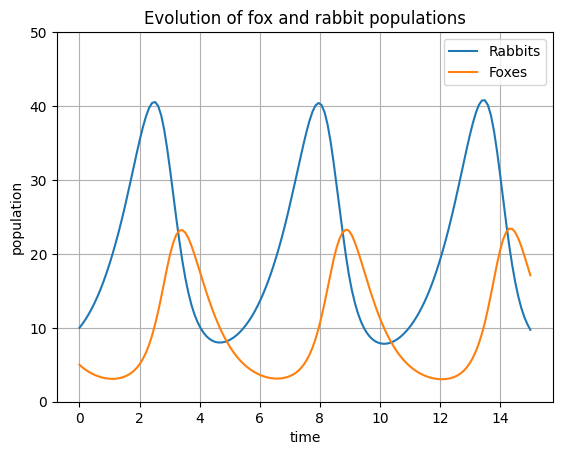

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, rabbits, label='Rabbits')
plt.plot(t, foxes, label='Foxes')
plt.grid()
plt.legend()
plt.ylim(0, 50)   # add some extra space at the top for the legend
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations');

The populations are indeed periodic, and their period is close to the
value T\_f1 that we computed.

Plotting direction fields and trajectories in the phase plane
-------------------------------------------------------------

We will plot some trajectories in a phase plane for different starting
points between X\_f0 and X\_f1.

We will use Matplotlib's colormap to define colors for the trajectories.
These colormaps are very useful to make nice plots. Have a look at [ShowColormaps](http://www.scipy.org/Cookbook/Matplotlib/Show_colormaps) if you want more information.

Here, the LSODA method is used instead of the default RK45 (Runge-Kutta of order 5); try changing the method and notice how some have larger instabilities, visible in the plot.
See [the SciPy solve_ivp documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) for more details on the various algorithms available.

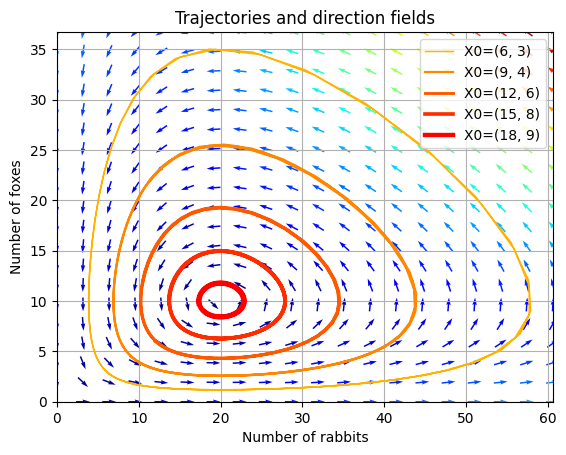

In [12]:
values = np.linspace(0.3, 0.9, 5)                          # position of X0 between X_f0 and X_f1
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))  # colors for each trajectory

plt.figure()
# plot trajectories
for v, col in zip(values, vcolors): 
    X0 = v * X_f1                               # starting point
    sol = solve_ivp(dX_dt, t_interval, X0, method='LSODA', t_eval=t)
    plt.plot(sol.y[0,:], sol.y[1,:], lw=3.5*v, color=col, label=f'X0=({X0[0]:.0f}, {X0[1]:.0f})')

values = np.linspace(0.3, 0.9, 5)                          # position of X0 between X_f0 and X_f1
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))  # colors for each trajectory
t = np.linspace(0, 15, 150)  # evaluate plots for plotting

# Define a grid and compute direction at each point
# Get the axis limits of the existing plot
ymax = plt.ylim(ymin=0)[1]
xmax = plt.xlim(xmin=0)[1] 
nb_points = 20                      

x = np.linspace(0, xmax, nb_points)
y = np.linspace(0, ymax, nb_points)

X1, Y1 = np.meshgrid(x, y)                      # create a grid
DX1, DY1 = dX_dt(0, [X1, Y1])                   # compute growth rate on the grid
M = np.hypot(DX1, DY1)                          # Norm of the growth rate 
M[ M == 0] = 1.                                 # Avoid zero division errors 
DX1 /= M                                        # Normalize each arrows
DY1 /= M


# Drow direction fields, using matplotlib 's quiver function
# I choose to plot normalized arrows and to use colors to give information on
# the growth speed
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.title('Trajectories and direction fields')
plt.legend()
plt.grid()
plt.xlim(0, xmax)
plt.ylim(0, ymax);

This graph shows us that changing either the fox or the rabbit
population can have an unintuitive effect. If, in order to decrease the
number of rabbits, we introduce foxes, this can lead to an increase of
rabbits in the long run, depending on the time of intervention.

Plotting contours
-----------------

We can verify that the function IF defined below remains constant along
a trajectory:

In [13]:
def IF(X):
    u, v = X
    return u**(c/a) * v * np.exp( -(b/a)*(d*u+v) )
    
# We will verify that IF remains constant for different trajectories
for v in values:
    X0 = v * X_f1                               # starting point
    sol = solve_ivp(dX_dt, t_interval, X0)
    I = IF(sol.y)                               # compute IF along the trajectory
    I_mean = I.mean()
    delta = 100 * (I.max()-I.min())/I_mean
    print(f'X0 = {X0[0]:.2f}, {X0[1]:.2f}) => I ~ {I_mean:.1f} | delta = {delta:.3G} %')

X0 = 6.00, 3.00) => I ~ 20.5 | delta = 4.56 %
X0 = 9.00, 4.50) => I ~ 38.9 | delta = 3.02 %
X0 = 12.00, 6.00) => I ~ 55.5 | delta = 2.32 %
X0 = 15.00, 7.50) => I ~ 67.0 | delta = 0.453 %
X0 = 18.00, 9.00) => I ~ 72.4 | delta = 0.102 %


Plotting iso-contours of IF can be a good representation of
trajectories, without having to integrate the ODE

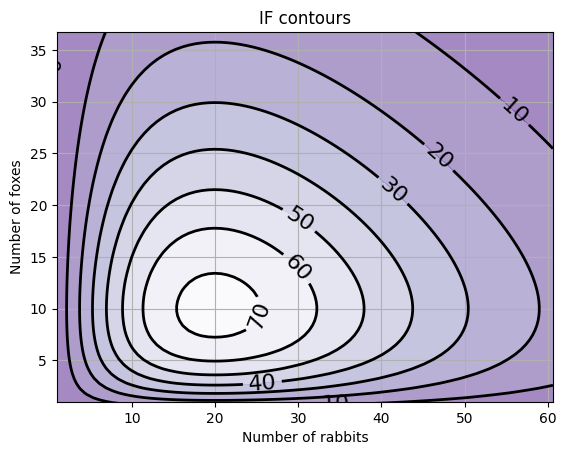

In [14]:
nb_points = 80                              # grid size
x = np.linspace(0, xmax, nb_points)
y = np.linspace(0, ymax, nb_points)
X2 , Y2 = np.meshgrid(x, y)                   # create the grid
Z2 = IF([X2, Y2])                           # compute IF on each point
CS = plt.contourf(X2, Y2, Z2, cmap=plt.cm.Purples_r, alpha=0.5)
CS2 = plt.contour(X2, Y2, Z2, colors='black', linewidths=2. )
plt.clabel(CS2, inline=1, fontsize=16, fmt='%.f')
plt.grid()
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.ylim(1, ymax)
plt.xlim(1, xmax)
plt.title('IF contours');